Look at rotation periods as a function of distance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.io import fits
from astropy.table import Table

In [2]:
dat = Table.read('kepler_dr2_4arcsec_updated.fits', format='fits')
d = dat.to_pandas()
print(np.shape(d), "Stars observed by both Gaia and Kepler")

(232844, 101) Stars observed by both Gaia and Kepler


In [3]:
M1 = pd.read_csv("Table_1_Periodic.txt")
print(np.shape(M1), "Kepler stars with McQuillan rotation periods")

(34030, 11) Kepler stars with McQuillan rotation periods


In [4]:
df = pd.merge(d, M1, how="inner", on="kepid", suffixes=["_gaia", "_KIC"])

In [5]:
print(np.shape(df))
df = df.drop_duplicates(subset="kepid")
print(np.shape(df))

(40359, 111)
(33375, 111)


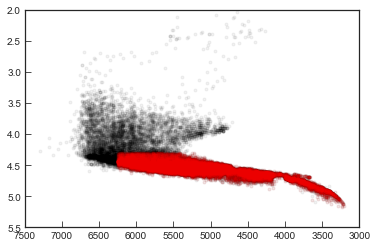

In [151]:
plt.plot(df.teff, df.logg_gaia, "k.", alpha=.05)
plt.xlim(7500, 3000)
plt.ylim(5.5, 2)

m = 10 < df.parallax_over_error.values  # Signal to noise greater than 10
m &= np.isfinite(df.radial_velocity.values)
#m &= df.radial_velocity.values != 0.
m &= df.teff.values < 6250
m &= 4.3 < df.logg_gaia.values

d = df.iloc[m]
plt.plot(d.teff, d.logg_gaia, "r.", alpha=.05)

(7000, 3000)

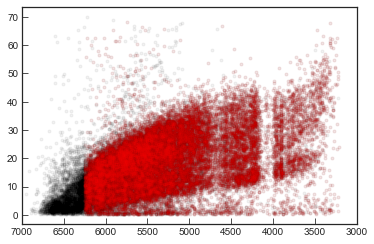

In [152]:
plt.plot(df.teff, df.Prot, "k.", alpha=.05)
plt.plot(d.teff, d.Prot, "r.", alpha=.05)
plt.xlim(7000, 3000)

(6250, 3000)

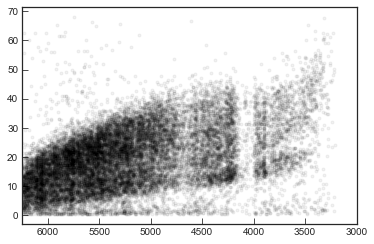

In [153]:
plt.plot(d.teff, d.Prot, "k.", alpha=.05)
plt.xlim(6250, 3000)

Select cool stars

(4000, 3200)

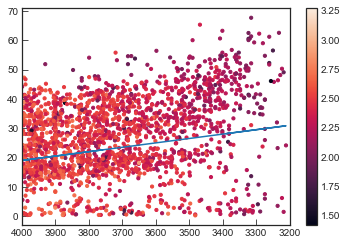

In [154]:
m = 3000 < d.teff.values
m &= d.teff.values < 4000
plt.scatter(d.teff.values[m], d.Prot[m], c=np.log10(d.r_est[m]), s=10)
plt.plot(d.teff.values[m], -.015 * d.teff.values[m] + 79)
plt.colorbar()
plt.xlim(4000, 3200)

(4000, 3200)

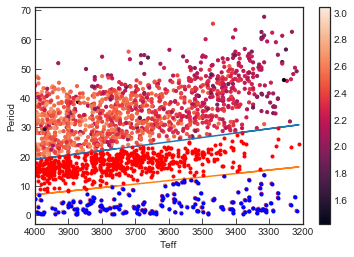

In [155]:
m2 = d.Prot[m] < -.015 * d.teff.values[m] + 79
m2 &= d.Prot[m] > -.012 * d.teff.values[m] + 55
m3 = d.Prot[m] < -.012 * d.teff.values[m] + 55
plt.scatter(d.teff.values[m][~m2], d.Prot[m][~m2], c=np.log10(d.r_est[m][~m2]), s=10)
plt.plot(d.teff.values[m], -.015 * d.teff.values[m] + 79)
plt.plot(d.teff.values[m], -.012 * d.teff.values[m] + 55)
plt.plot(d.teff.values[m][m2], d.Prot[m][m2], "r.")
plt.plot(d.teff.values[m][m3], d.Prot[m][m3], "b.")
plt.xlabel("Teff")
plt.ylabel("Period")
plt.colorbar()
plt.xlim(4000, 3200)

(0.023624218770580133, 0.5056881016832667)


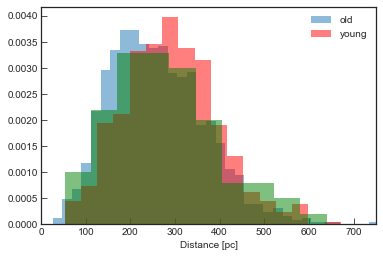

In [156]:
m2 = d.Prot[m] < -.015 * d.teff.values[m] + 79
plt.hist(d.r_est.values[m][~m2], 50, normed=True, alpha=.5, label="old");
plt.hist(d.r_est.values[m][m2], 50, normed=True, alpha=.5, color="r", label="young");
plt.hist(d.r_est.values[m][m3], 10, normed=True, alpha=.5, color="g");
plt.legend()
plt.xlabel("Distance [pc]")
plt.xlim(0, 750)

x = np.random.choice(d.r_est.values[m][~m2], len(d.r_est.values[m][m2]))
print(sps.pearsonr(x, d.r_est.values[m][m2]))

In [157]:
from actions import action
from tqdm import tqdm

actions = np.zeros((len(d.kepid.values[m]), 9))
for i in tqdm(range(len(d.kepid.values[m]))):
    actions[i, :] = action(d.ra.values[i], d.dec.values[i], d.r_est.values[i]*1e-3, 
                           d.pmra.values[i], d.pmdec.values[i], d.radial_velocity.values[i])

100%|██████████| 2021/2021 [00:32<00:00, 62.49it/s]


In [81]:
labels = ["$R [kpc]$", "$\phi [rad]$", "z_kpc", "vR_kms", "vT_kms", "vz_kms", "jR", "lz", "jz"]

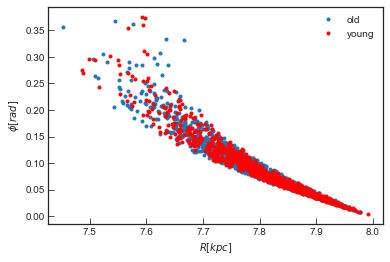

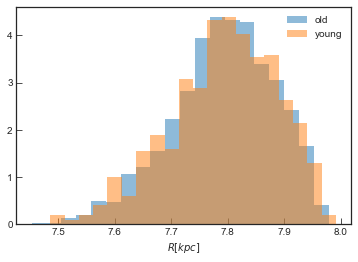

old median =  7.7975221353905315 young median =  7.800068393434255
old variance =  0.008182933710779123 young variance =  0.008847356321865405
(0.058351302951397545, 0.0999476220536435)


In [138]:
import scipy.stats as sps

def make_ndplots(actions, m2, labels, i, nbins, logx=False, logy=False):
    
    x_old = actions[:, i][~m2]
    x_young = actions[:, i][m2]
    y_old = actions[:, i+1][~m2]
    y_young = actions[:, i+1][m2]
    
    if logx:
        x_old = np.log10(actions[:, i][~m2])
        x_young = np.log10(actions[:, i][m2])
        
    if logy:
        y_old = np.log10(actions[:, i+1][~m2])
        y_young = np.log10(actions[:, i+1][m2])

    plt.plot(x_old, y_old, ".", label="old")
    plt.plot(x_young, y_young, "r.", label="young")
    plt.legend()
    plt.xlabel(labels[i])
    plt.ylabel(labels[i+1])
    plt.show()

    plt.hist(x_old, nbins, label="old", normed=True, alpha=.5)
    plt.hist(x_young, nbins, label="young", normed=True, alpha=.5)
    plt.legend()
    plt.xlabel(labels[i])
    plt.show()
    
    print("old median = ", np.median(x_old), "young median = ", np.median(x_young))
    print("old variance = ", np.var(x_old), "young variance = ", np.var(x_young))
    
    old = np.random.choice(x_old, len(x_young))
    print(sps.pearsonr(old, x_young))
    
make_ndplots(actions, m2, labels, 0, 20)

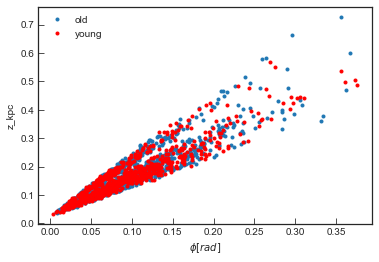

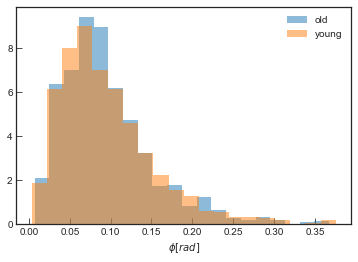

old median =  0.08466688372745489 young median =  0.0817941704939674
old variance =  0.0030698414758981514 young variance =  0.0034257414351606588
(-0.028859280425604067, 0.416154808987909)


In [139]:
make_ndplots(actions, m2, labels, 1, 20)

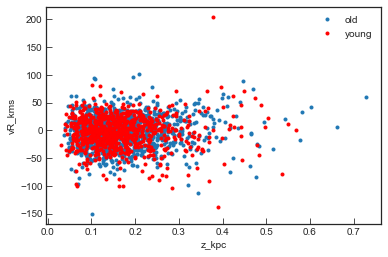

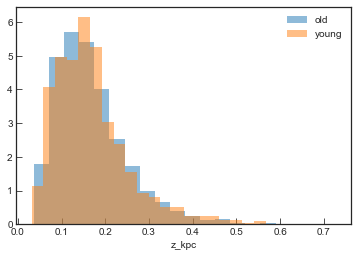

old median =  0.15209460813194772 young median =  0.15419756257295036
old variance =  0.007399866285803674 young variance =  0.007437057769719341
(0.04086708129338402, 0.24945610217578296)


In [140]:
make_ndplots(actions, m2, labels, 2, 20)

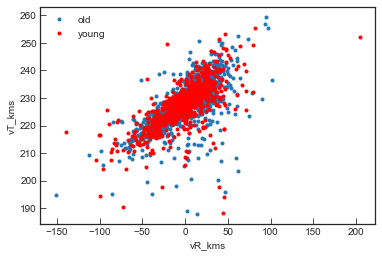

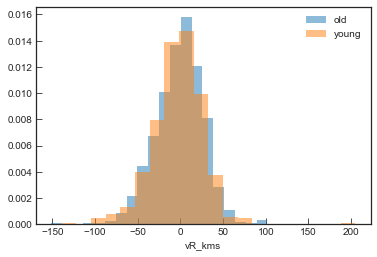

old median =  1.1851885313574924 young median =  -0.9978033799710566
old variance =  773.5198251046328 young variance =  886.1854290781816
(0.005108857201775771, 0.8855691490800033)


In [141]:
make_ndplots(actions, m2, labels, 3, 20)

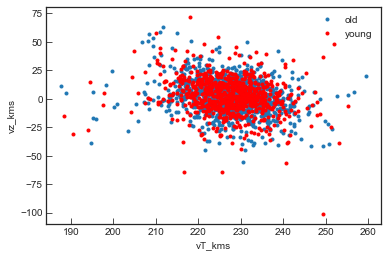

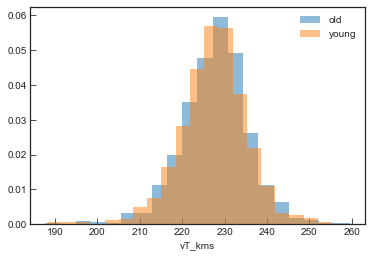

old median =  228.2643529448988 young median =  227.58583331097032
old variance =  64.46705307019785 young variance =  65.27400991362231
(0.05474396277069711, 0.12277075022567778)


In [142]:
make_ndplots(actions, m2, labels, 4, 20)

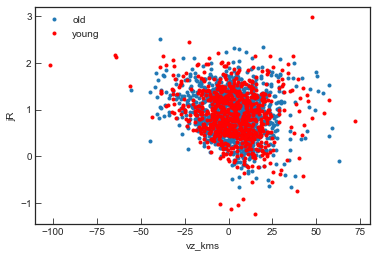

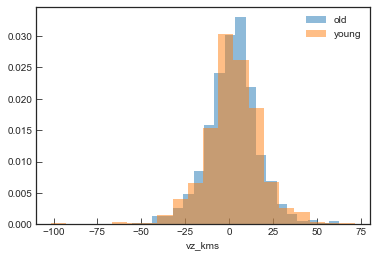

old median =  2.6891335184624845 young median =  2.3310934160732764
old variance =  215.98689922612374 young variance =  253.39333780839547
(0.034816914016825115, 0.3265632546681463)


In [143]:
make_ndplots(actions, m2, labels, 5, 20, logy=True)

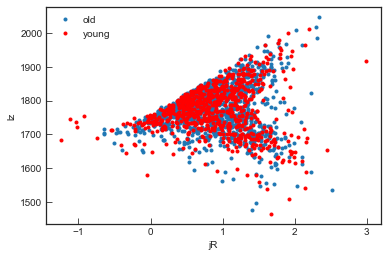

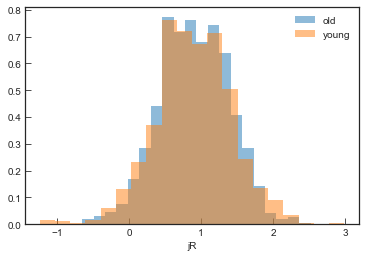

old median =  0.8863863072776369 young median =  0.889551373822855
old variance =  0.23539082623657995 young variance =  0.287135855810906
(-0.014978509684981399, 0.6730576228205081)


In [144]:
make_ndplots(actions, m2, labels, 6, 20, logx=True)

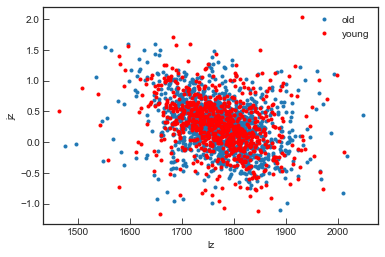

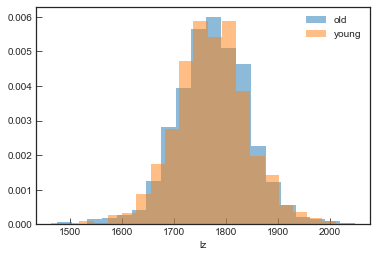

old median =  1774.9835826906342 young median =  1771.1736535742393
old variance =  4827.240322708267 young variance =  4990.570241250891
(-0.003560134176302202, 0.9201170992011886)


In [145]:
make_ndplots(actions, m2, labels, 7, 20, logy=True)